In [160]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
from IPython.display import display



In [161]:
#Cargar y preparar los datos
try:
    df = pd.read_csv("McDonald.csv", encoding='latin1')
except FileNotFoundError:
    print("Error: El archivo 'McDonalds_Reviews.csv' no se encuentra.")
    print("Por favor, asegúrate de que el archivo está en el mismo directorio.")
    exit()


In [162]:
#imprimir
df.head()

,reviewer_id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating
0,1,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 months ago,Why does it look like someone spit on my food?...,1 star
1,2,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,It'd McDonalds. It is what it is as far as the...,4 stars
2,3,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,Made a mobile order got to the speaker and che...,1 star
3,4,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",a month ago,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5 stars
4,5,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",2 months ago,"I repeat my order 3 times in the drive thru, a...",1 star


In [163]:
#verificar columnas
df.columns

Index(['reviewer_id', 'store_name', 'category', 'store_address', 'latitude ',
       'longitude', 'rating_count', 'review_time', 'review', 'rating'],
      dtype='object')

In [164]:
# Crear un DataFrame de ejemplo
data = {'review': ['Buen servicio y comida deliciosa.', 'La comida estaba fría y el lugar sucio.',
                   'Me encantan sus papas fritas.', 'El personal es lento, mala experiencia.',
                   'Todo perfecto, volveré pronto.', 'Nunca más volveré, horrible lugar.',
                   'El café estaba bien, pero la fila era muy larga.', 'Me gustó el ambiente.',
                   'El servicio es lento.', 'Una experiencia terrible.', 'Muy buen restaurante.'],
        'rating': [5, 1, 5, 2, 4, 1, 3, 4, 2, 1, 5]}
df = pd.DataFrame(data)

In [165]:
#Verificar los valores nulos con la función null_count()
def null_count(df_to_check):
    return pd.DataFrame({'features': df_to_check.columns,
                         'dtypes': df_to_check.dtypes.values,
                         'NaN count': df_to_check.isnull().sum().values,
                         'NaN percentage': df_to_check.isnull().sum().values / df_to_check.shape[0]}).style.background_gradient(cmap='turbo', low=0.1, high=0.01)

print("Resumen de valores nulos:")
display(null_count(df))


Resumen de valores nulos:


,features,dtypes,NaN count,NaN percentage
0,review,object,0,0.000000
1,rating,int64,0,0.000000


In [166]:
df.duplicated().sum()

np.int64(0)

In [167]:
#Calcular los valores no nulos por columna
non_null_counts = df.count()

<Axes: >

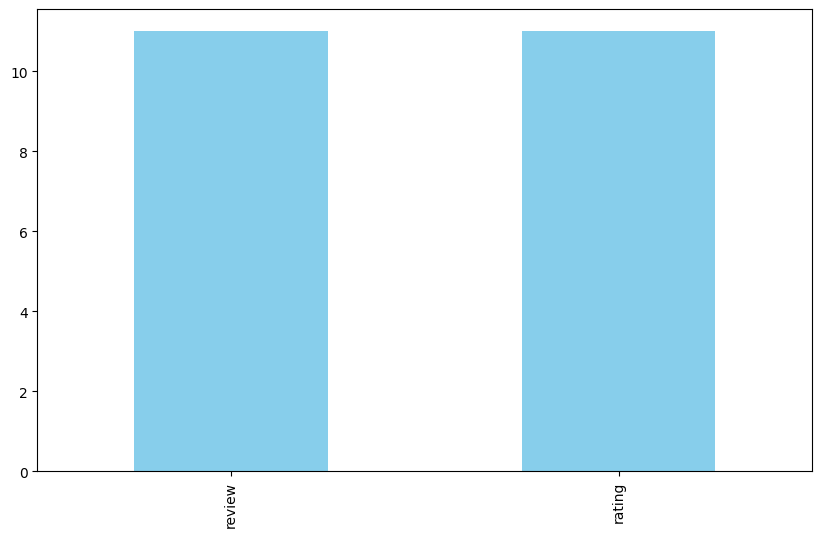

In [168]:
#Crear el gráfico de barras
plt.figure(figsize=(10, 6)) # Define el tamaño del gráfico
non_null_counts.plot(kind='bar', color='skyblue') # Usa el método de plot de Pandas#

In [169]:
#Eliminar filas con valores nulos en 'review' y 'rating'
df.dropna(subset=['review', 'rating'], inplace=True)


In [170]:
# Clasificación de sentimientos
df['sentiment'] = df['rating'].apply(lambda x: 'positivo' if x >= 4 else ('neutral' if x == 3 else 'negativo'))

In [171]:
# Definir las variables X e y
X = df['review'].values
y = df['sentiment'].values


Preprocesamiento de texto para Deep Learning

In [172]:
# Tokenización de texto
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X)
X_sequences = tokenizer.texts_to_sequences(X)
word_index = tokenizer.word_index


In [173]:
# Padding de  secuencias con la misma longitud
max_sequence_len = max([len(x) for x in X_sequences])
X_padded = pad_sequences(X_sequences, maxlen=max_sequence_len, padding='post')


In [174]:
# Conversión de etiquetas a formato binario
lb = LabelBinarizer()
y_encoded = lb.fit_transform(y)
num_classes = len(lb.classes_)

In [175]:
# División de datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_encoded, test_size=0.2, random_state=42)


modelo de Deep Learning (LSTM)

In [176]:
model = Sequential()
model.add(Embedding(input_dim=len(word_index) + 1, output_dim=128, input_length=max_sequence_len)) ## Capa de Embedding: Mapea los índices de enteros a vectores densos.
model.add(LSTM(128)) # Capa LSTM: Captura dependencias a largo plazo en secuencias.
model.add(Dropout(0.5)) # Capa Dropout: Previene el sobreajuste.
model.add(Dense(3, activation='softmax')) # Capa de salida: Clasificación multiclase.

print("Resumen de valores nulos:")
display(null_count(df))


Resumen de valores nulos:


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


,features,dtypes,NaN count,NaN percentage
0,review,object,0,0.000000
1,rating,int64,0,0.000000
2,sentiment,object,0,0.000000


In [177]:
#entrenar modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

epochs = 10
batch_size = 32
history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.1,
                    verbose=1)

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_18 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4286 - loss: 1.0920 - val_accuracy: 0.0000e+00 - val_loss: 1.1059
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.5714 - loss: 1.0641 - val_accuracy: 0.0000e+00 - val_loss: 1.1179
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5714 - loss: 1.0256 - val_accuracy: 0.0000e+00 - val_loss: 1.1306
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7143 - loss: 1.0049 - val_accuracy: 0.0000e+00 - val_loss: 1.1444
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.7143 - loss: 0.9583 - val_accuracy: 0.0000e+00 - val_loss: 1.1594
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7143 - loss: 0.9356 - val_accuracy: 0.0000e+00 - val_loss: 1.1764
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5714 - loss: 0.8930 - val_accuracy: 0.0000e+00 - val_loss: 1.1964
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.5714 - loss: 0.8916 - val_accuracy: 

In [178]:
MAX_FEATS = 5000 ## Cantidad de caracteristicas que queremos obtener del texto crudo

In [179]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input

model = Sequential([
    Embedding(input_dim=MAX_FEATS + 1, output_dim=128, input_length=max_sequence_len),  #Capa Inicial con 50000 neuronas
    LSTM(128),  # Capa LSTM con 128 neuronas
    Dropout(0.5),  # Capa Dropout para prevenir sobreajuste
    Dense(64, activation='relu'), # Capa oculta con 64 neuronas
    Dense(32, activation='relu'), # Capa oculta con 32 neuronas
    Dense(3, activation='softmax')  # Capa de salida para clasificación multiclase (3 clases)
])

# Compilar modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy', # Usar 'categorical_crossentropy' para 3 o más clases
              metrics=['accuracy'])

# Resumen del modelo
model.summary()

c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_19 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)